In [977]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [978]:
import numpy as np

from matplotlib import pyplot as plt

from modules import utils, fitting

import importlib
importlib.reload(utils)
importlib.reload(fitting)

utils.set_plot_configs()

In [979]:
class PhotoelectricData:
    def _read_data(self,data_file):

        V = np.array([])
        Is = []

        with open(data_file,'r') as f:
            for line in f.readlines():
                if line.startswith("#"):
                    continue

                line_data = line.split()
                
                V = np.append(V,float(line_data[0]))
                Is.append(np.array([
                    float(x) for x in line_data[1:]
                ]))

        return V, Is

    def _analyse_single_bin(self,I):
        
        bayes_gaussian = fitting.BayesianGaussian(I)

        return bayes_gaussian.mu, bayes_gaussian.sigma, bayes_gaussian.chisqr
    
    def _analyse_all_bins(self,Is):

        I_mu = np.array([])
        I_sigma = np.array([])
        I_reduced_chisqr = np.array([])

        for I in Is:
            mu, sigma, chisqr = self._analyse_single_bin(I)

            I_mu = np.append(I_mu,mu)
            I_sigma = np.append(I_sigma,sigma)
            I_reduced_chisqr = np.append(I_reduced_chisqr,chisqr/I.shape[0])

        return I_mu, I_sigma, I_reduced_chisqr

In [980]:
class PhotoelectricBaseline(PhotoelectricData):
    def __init__(self,folder):
        self._get_baseline(folder)

    def _get_baseline(self,folder):
        self.lambdas = []

        self.V = {}
        self.I_mu = {}
        self.I_sigma = {}

        for file in os.scandir(folder):
            if file.is_file() and file.name.endswith('_base.txt'):
                wavelength = file.name.split('_')[0]
                self.lambdas.append(wavelength)

                V, Is = self._read_data(file.path)
                I_mu, I_sigma, I_reduced_chisqr = self._analyse_all_bins(Is)

                self.V[wavelength] = V
                self.I_mu[wavelength] = I_mu
                self.I_sigma[wavelength] = I_sigma

        self.lambdas = sorted(self.lambdas,key=lambda x: float(x[:3]))

In [981]:
photoelectric_baseline = PhotoelectricBaseline('data/25-02-25/')

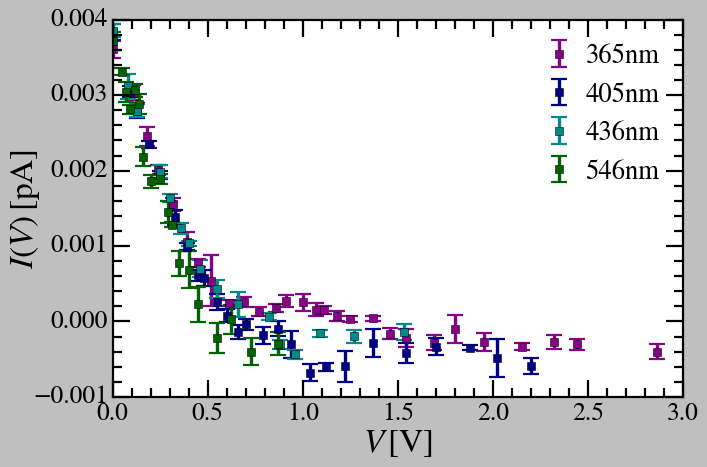

In [982]:
fig, ax = plt.subplots(figsize=(9,6))

colors = {
    '365nm' : 'darkmagenta',
    '405nm' : 'darkblue',
    '436nm' : 'darkcyan',
    '546nm' : 'darkgreen',
}

for wavelength in photoelectric_baseline.lambdas:
    ax.errorbar(photoelectric_baseline.V[wavelength],photoelectric_baseline.I_mu[wavelength],yerr=photoelectric_baseline.I_sigma[wavelength],
                label=wavelength,color=colors[wavelength],fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,capthick=2)

ax.legend(loc='upper right', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)

ax.set_xlabel(r'$V \, [{\rm{V}}]$')
ax.set_ylabel(r'$I (V) \, [{\rm{pA}}]$',labelpad=-8)

plt.tight_layout()
plt.savefig('background.png')

plt.show()

In [983]:
class BisegmentFitter(fitting.BaseFitter):
    def __init__(self,
                 x, y, yerr,
                 order=3,
                 initial_boundary_guess=0.4):
        super().__init__(x,y,yerr)

        self.order = order
        self.initial_boundary_guess = initial_boundary_guess

    def _get_initial_guess(self):
        return np.append([self.initial_boundary_guess],np.zeros(self.order+1))
    
    def _get_model(self, x, params):
        x0, *poly_params = params

        y0 = np.polyval(poly_params,x0)
        dydx0 = np.polyval(np.polyder(poly_params),x0)

        return np.piecewise(
            x, [x<x0,x>=x0],
            [
                lambda x: np.polyval(poly_params,x),
                lambda x: y0 + dydx0*(x-x0),
            ]
        )

class PhotoelectricMeasurement(PhotoelectricData):
    def __init__(self,data_file_base='data/25-02-25/356nm'):
        self.V_pe, self.Is_pe = self._read_data(data_file_base+'.txt')
        self.I_mu_pe, self.I_sigma_pe, self.I_reduced_chisqr_pe = self._analyse_all_bins(self.Is_pe)

        self.V_base, self.Is_base = self._read_data(data_file_base+'_base.txt')
        self.I_mu_base, self.I_sigma_base, self.I_reduced_chisqr_base = self._analyse_all_bins(self.Is_base)
        
        if np.any(self.V_pe != self.V_base):
            raise ValueError('Wavelengths do not match between photoelectric and baseline data')
        self.V = self.V_pe

        self.I_mu = self.I_mu_pe - self.I_mu_base
        self.I_sigma = np.sqrt(self.I_sigma_pe**2 + self.I_sigma_base**2)

    def fit_Chow_polynomial(self,mask=None):
        if mask is None:
            mask = np.ones(self.V.shape,dtype=bool)
            
        x = self.V[mask]
        y = self.I_mu[mask]
        yerr = self.I_sigma[mask]
        
        chow_fitter = fitting.ChowPolynomial(x,y,yerr)
        return chow_fitter.fit(), chow_fitter
    
    def fit_bisegment(self,order=3,initial_boundary_guess=0):
        bisegment_fitter = BisegmentFitter(
            self.V,self.I_mu,self.I_sigma,
            order=order,
            initial_boundary_guess=initial_boundary_guess
        )
        return bisegment_fitter.fit(), bisegment_fitter
    
    def get_uniform_MC_bisegment(self,Verr=0.005,N_sample=10000):
        uniform_MC_bisegment_fitter = fitting.BaseUniformMonteCarloFitter(
            self.V,Verr*np.ones(self.V.shape),self.I_mu,self.I_sigma,
            fitter=BisegmentFitter,N_sample=N_sample
        )
        return uniform_MC_bisegment_fitter.fit()

In [984]:
wavelength = '546nm'

photoelectric_data = PhotoelectricMeasurement(data_file_base=f'data/25-02-25/{wavelength}')

[ 0.22260733 -0.70106335  0.76341447 -0.34735452  0.05295476]


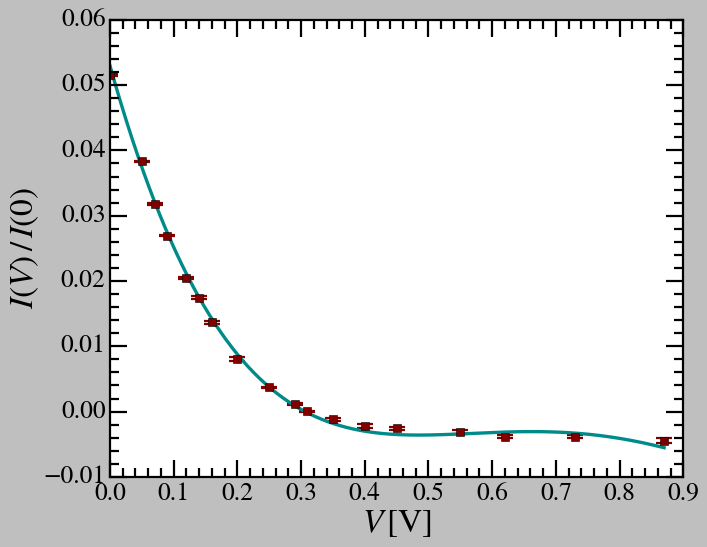

In [985]:
fig, ax = plt.subplots(figsize=(9,7))

ax.errorbar(photoelectric_data.V,photoelectric_data.I_mu,yerr=photoelectric_data.I_sigma,
            label='Data',color='maroon',fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,capthick=2)

chow_fitting_result, chow_fitter = photoelectric_data.fit_Chow_polynomial()
print(chow_fitting_result['params'])
V_fit = np.linspace(photoelectric_data.V[0],photoelectric_data.V[-1],1000)
ax.plot(V_fit,chow_fitter._get_model(V_fit,chow_fitting_result['params']),label='Chow Polynomial',color='darkcyan')

ax.set_xlabel(r'$V \, [{\rm{V}}]$')
ax.set_ylabel(r'$I (V) \, / \, I (0)$')

plt.tight_layout()
plt.show()

In [986]:
positive_orders = {
    '365nm' : 3,
    '405nm' : 3,
    '436nm' : 3,
    '546nm' : 3,
}

In [987]:
colors = {
    '365nm' : 'darkmagenta',
    '405nm' : 'darkblue',
    '436nm' : 'darkcyan',
    '546nm' : 'darkgreen',
}

zorders = {
    '365nm' : -7,
    '405nm' : -5,
    '436nm' : -3,
    '546nm' : -1,
}

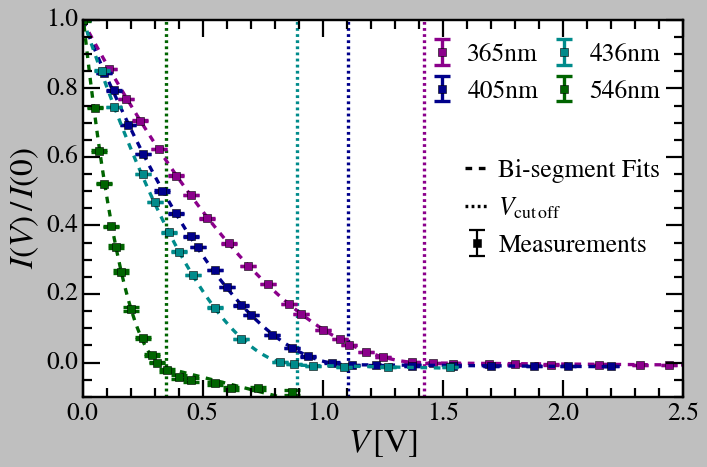

In [988]:
fig, ax = plt.subplots(figsize=(9,6))

for wavelength in ['365nm','405nm','436nm','546nm']:
    photoelectric_data = PhotoelectricMeasurement(data_file_base=f'data/25-02-25/{wavelength}')

    I0 = photoelectric_data.I_mu[0]

    ax.errorbar(photoelectric_data.V,photoelectric_data.I_mu/I0,
                yerr=photoelectric_data.I_sigma/I0,
                label=wavelength,color=colors[wavelength],zorder=zorders[wavelength],
                fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,capthick=3,)
    
    bisegment_fitting_result, bisegment_fitter = photoelectric_data.fit_bisegment(
        order=positive_orders[wavelength],
        initial_boundary_guess=0.4
    )

    V_fit, I_fit = bisegment_fitter.model_interpolation(params=bisegment_fitting_result['params'])

    ax.plot(V_fit,I_fit/I0,
            color=colors[wavelength],zorder=zorders[wavelength]-1,
            linestyle='--')
    ax.axvline(bisegment_fitting_result['params'][0],
               color=colors[wavelength],zorder=-9,
               linestyle='--',dashes=(2.5,3))

ax.legend(loc='upper right', ncol=2, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=23)

ax_extra = ax.twinx()
ax_extra.errorbar([100],[100],yerr=[100],
                  label='Measurements',color='black',
                  fmt=' s',markersize=7.5,elinewidth=2,capsize=7.5,capthick=2,)
ax_extra.plot([100],[100],color='black',linestyle='--',label='Bi-segment Fits')
ax_extra.plot([100],[100],color='black',linestyle='--',dashes=(2.5,3),label=r'$V_{\rm{cut\,off}}$')
ax_extra.legend(loc='center right', frameon=False, fontsize=23, ncol=1, handletextpad=0.4, handlelength=0.9, columnspacing=0.5)
ax_extra.set_yticks([])
ax_extra.tick_params(axis='y', which='both',direction='in',right=False)
ax.tick_params(axis='both', which='both',direction='in',top=True,right=True)

ax.set_xlabel(r'$V \, [{\rm{V}}]$')
ax.set_ylabel(r'$I (V) \, / \, I (0)$',labelpad=5)

ax.set_xlim(0,2.5)
ax.set_ylim(-0.1,1)

plt.tight_layout()
plt.savefig('measurements.png')

plt.show()

100%|██████████| 10000/10000 [02:06<00:00, 78.87it/s]


365nm 1.4244600353574381 0.010165854485957086


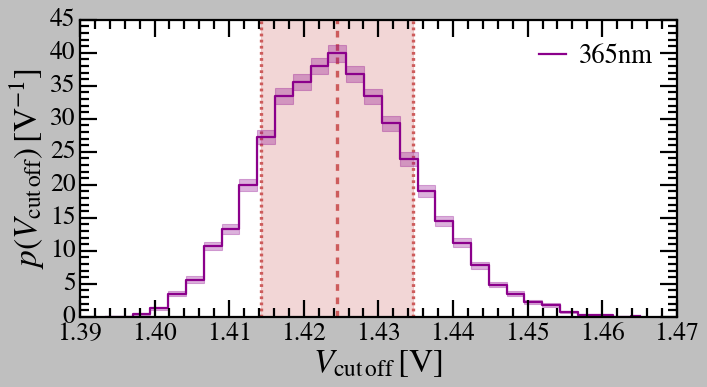

100%|██████████| 10000/10000 [01:37<00:00, 103.08it/s]


405nm 1.1044366685793208 0.014381911736601647


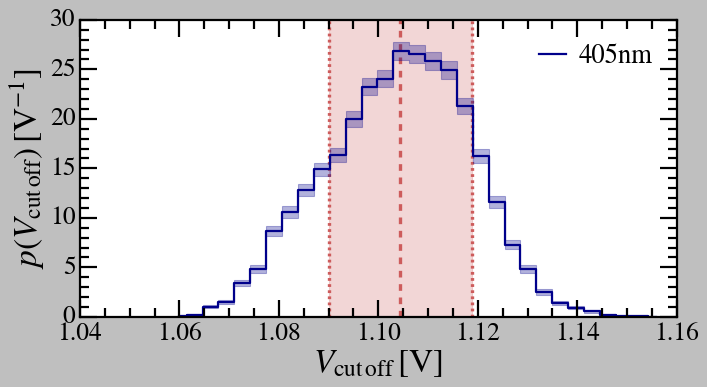

100%|██████████| 10000/10000 [01:24<00:00, 117.92it/s]


436nm 0.8855083443711683 0.014769874392674824


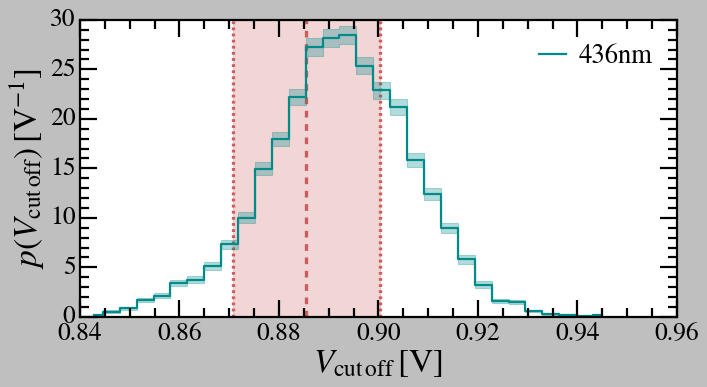

 44%|████▎     | 4372/10000 [00:33<00:43, 129.52it/s]/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/fitting.py:40: RuntimeWarning: invalid value encountered in sqrt
  e_params = np.sqrt(np.diagonal(cov))
100%|██████████| 10000/10000 [01:16<00:00, 131.07it/s]


546nm 0.3126555656116693 0.058431635164882145


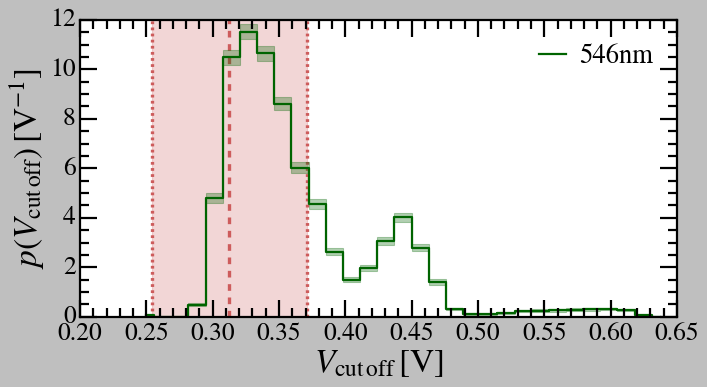

In [989]:
for wavelength in ['365nm','405nm','436nm','546nm']:
    photoelectric_data = PhotoelectricMeasurement(data_file_base=f'data/25-02-25/{wavelength}')

    _, _, params, e_params = photoelectric_data.get_uniform_MC_bisegment(Verr=0.005,N_sample=10000)

    mask = params[:,0] > 0.1
    params = params[mask]
    e_params = e_params[mask]

    weights = 1/e_params**2
    params_mean = np.sum(weights*params,axis=0)/np.sum(weights,axis=0)
    params_std = np.sqrt(np.var(params,axis=0) + 1/np.sum(weights,axis=0))

    print(wavelength,params_mean[0],params_std[0])

    fig, ax = plt.subplots(figsize=(9,5))

    counts, bins = np.histogram(params[:,0],bins=31)
    counts_err = np.sqrt(counts)
    normalizer = np.sum(counts) * (bins[1]-bins[0])

    bin_centers = (bins[1:]+bins[:-1])/2

    ax.plot(bin_centers,counts/normalizer,drawstyle='steps-mid',color=colors[wavelength],linewidth=2,label=wavelength,zorder=-1)
    ax.fill_between(bin_centers,(counts-counts_err)/normalizer,(counts+counts_err)/normalizer,step='mid',color=colors[wavelength],alpha=0.3,zorder=-2)
    
    ax.axvline(params_mean[0],color='indianred',linestyle='--',zorder=-3)
    ax.axvline(params_mean[0]-params_std[0],color='indianred',linestyle='--',dashes=(2.5,3),zorder=-3)
    ax.axvline(params_mean[0]+params_std[0],color='indianred',linestyle='--',dashes=(2.5,3),zorder=-3)
    ax.axvspan(params_mean[0]-params_std[0],params_mean[0]+params_std[0],color='indianred',alpha=0.25,zorder=-4)

    ax.set_xlabel(r'$V_{\rm{cut\,off}} \, [{\rm{V}}]$')
    ax.set_ylabel(r'$p(V_{\rm{cut\,off}}) \, [{\rm{V}}^{-1}]$')

    ax.legend(loc='upper right', ncol=2, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)

    plt.tight_layout()
    plt.savefig(f'V_cutoff_{wavelength}.png')

    plt.show()